In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "8" # export OMP_NUM_THREADS=8

# How to produce one ghost ?

In [2]:
import batoid
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import math
from collections import Counter

In [3]:
# Loading LSST geometry
# Also, you can change the filter (replace the g by i, r, u, y or z, for others see the batoid documentation)
telescope = batoid.Optic.fromYaml("ComCam_r.yaml")

for surface in telescope.itemDict.values():
    if isinstance(surface, batoid.RefractiveInterface):
        if surface.name.split('_')[0] in ['L1', 'L2', 'L3']:
            surface.forwardCoating = batoid.SimpleCoating(0.05, 0.95)
            surface.reverseCoating = batoid.SimpleCoating(0.05, 0.95)
        elif surface.name.split('_')[0] in ['Filter']:
            surface.forwardCoating = batoid.SimpleCoating(0.05, 0.95)
            surface.reverseCoating = batoid.SimpleCoating(0.05, 0.95)
    if isinstance(surface, batoid.Detector):
        surface.forwardCoating = batoid.SimpleCoating(0.15, 0.85)

In [4]:
# Initialise theta_x and theta_y as you want
theta_x = -0.2250
theta_y = -0.0085

In [5]:
# Start the calculus
rays = batoid.RayVector.asPolar(
        telescope, wavelength=630e-9,
        theta_x=np.deg2rad(theta_x), theta_y=np.deg2rad(theta_y),
        naz=900, nrad=600, flux=1.0
    )
rForward, rReverse = telescope.traceSplit(rays, minFlux=1e-5)

In [6]:
# Note the reference optic way
ref = ['L1_entrance', 'L1_exit', 'L2_entrance', 'L2_exit', 'Filter_entrance', 'Filter_exit', 'L3_entrance', 'L3_exit', 'Detector']

In [7]:
paths = []

for i in range(len(rForward)):
    paths.append([path for path in rForward[i].path if path in ref])

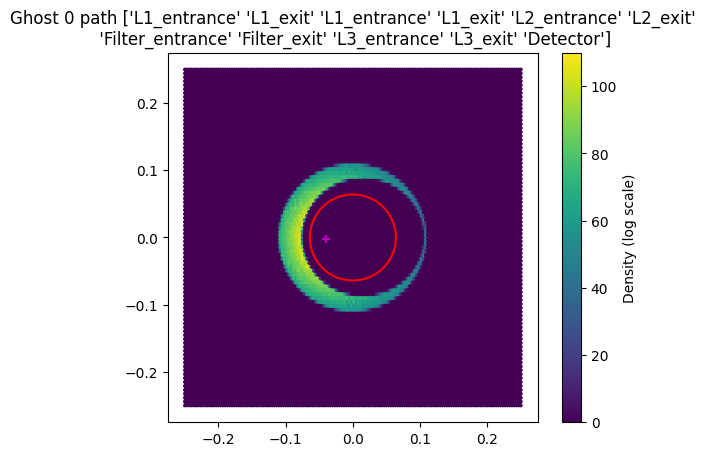

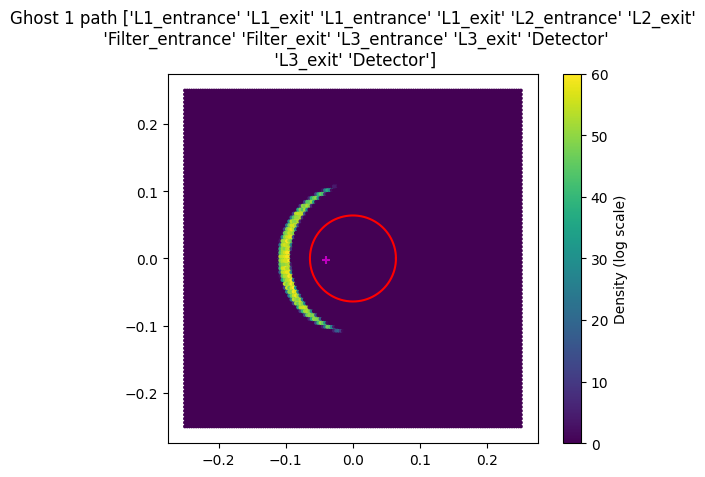

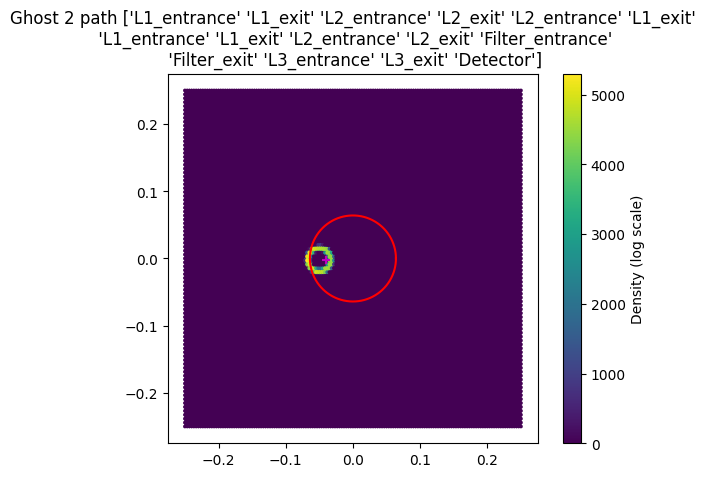

In [8]:
# Plot first n ghost
n = 3

for i, rr in enumerate(rForward[:n]):
    hb = plt.hexbin(rr.x, rr.y, extent=[-0.25, 0.25, -0.25, 0.25], gridsize=150)
    # plot approximate focal plane radius
    th = np.linspace(0, 2*np.pi, 1000)
    plt.plot(0.32/5*np.cos(th), 0.32/5*np.sin(th), c='r')
    # plot direct path location on focal plane
    # direct path will be rForward with fewest number of things in "path"
    w = np.argmin([len(rrr.path) for rrr in rForward])
    plt.scatter(np.mean(rForward[w].x), np.mean(rForward[w].y), marker='+', color='m')
    plt.gca().set_aspect("equal")
    plt.colorbar(hb, label="Density (log scale)")
    plt.title(f"Ghost {i} path {np.array(paths[i])}")
    plt.show()

# How to have all ghosts on a subplot ?

In [9]:
# Start by define a function to know how many rows and columns we need
def get_subplot_grid(num_subplots):
    """Retourne (n_rows, n_cols) pour organiser num_subplots en subplots équilibrés."""
    n_cols = math.ceil(math.sqrt(num_subplots))
    n_rows = math.ceil(num_subplots / n_cols)
    return n_rows, n_cols

In [10]:
# Take back their
nrows, ncols = get_subplot_grid(len(rForward))

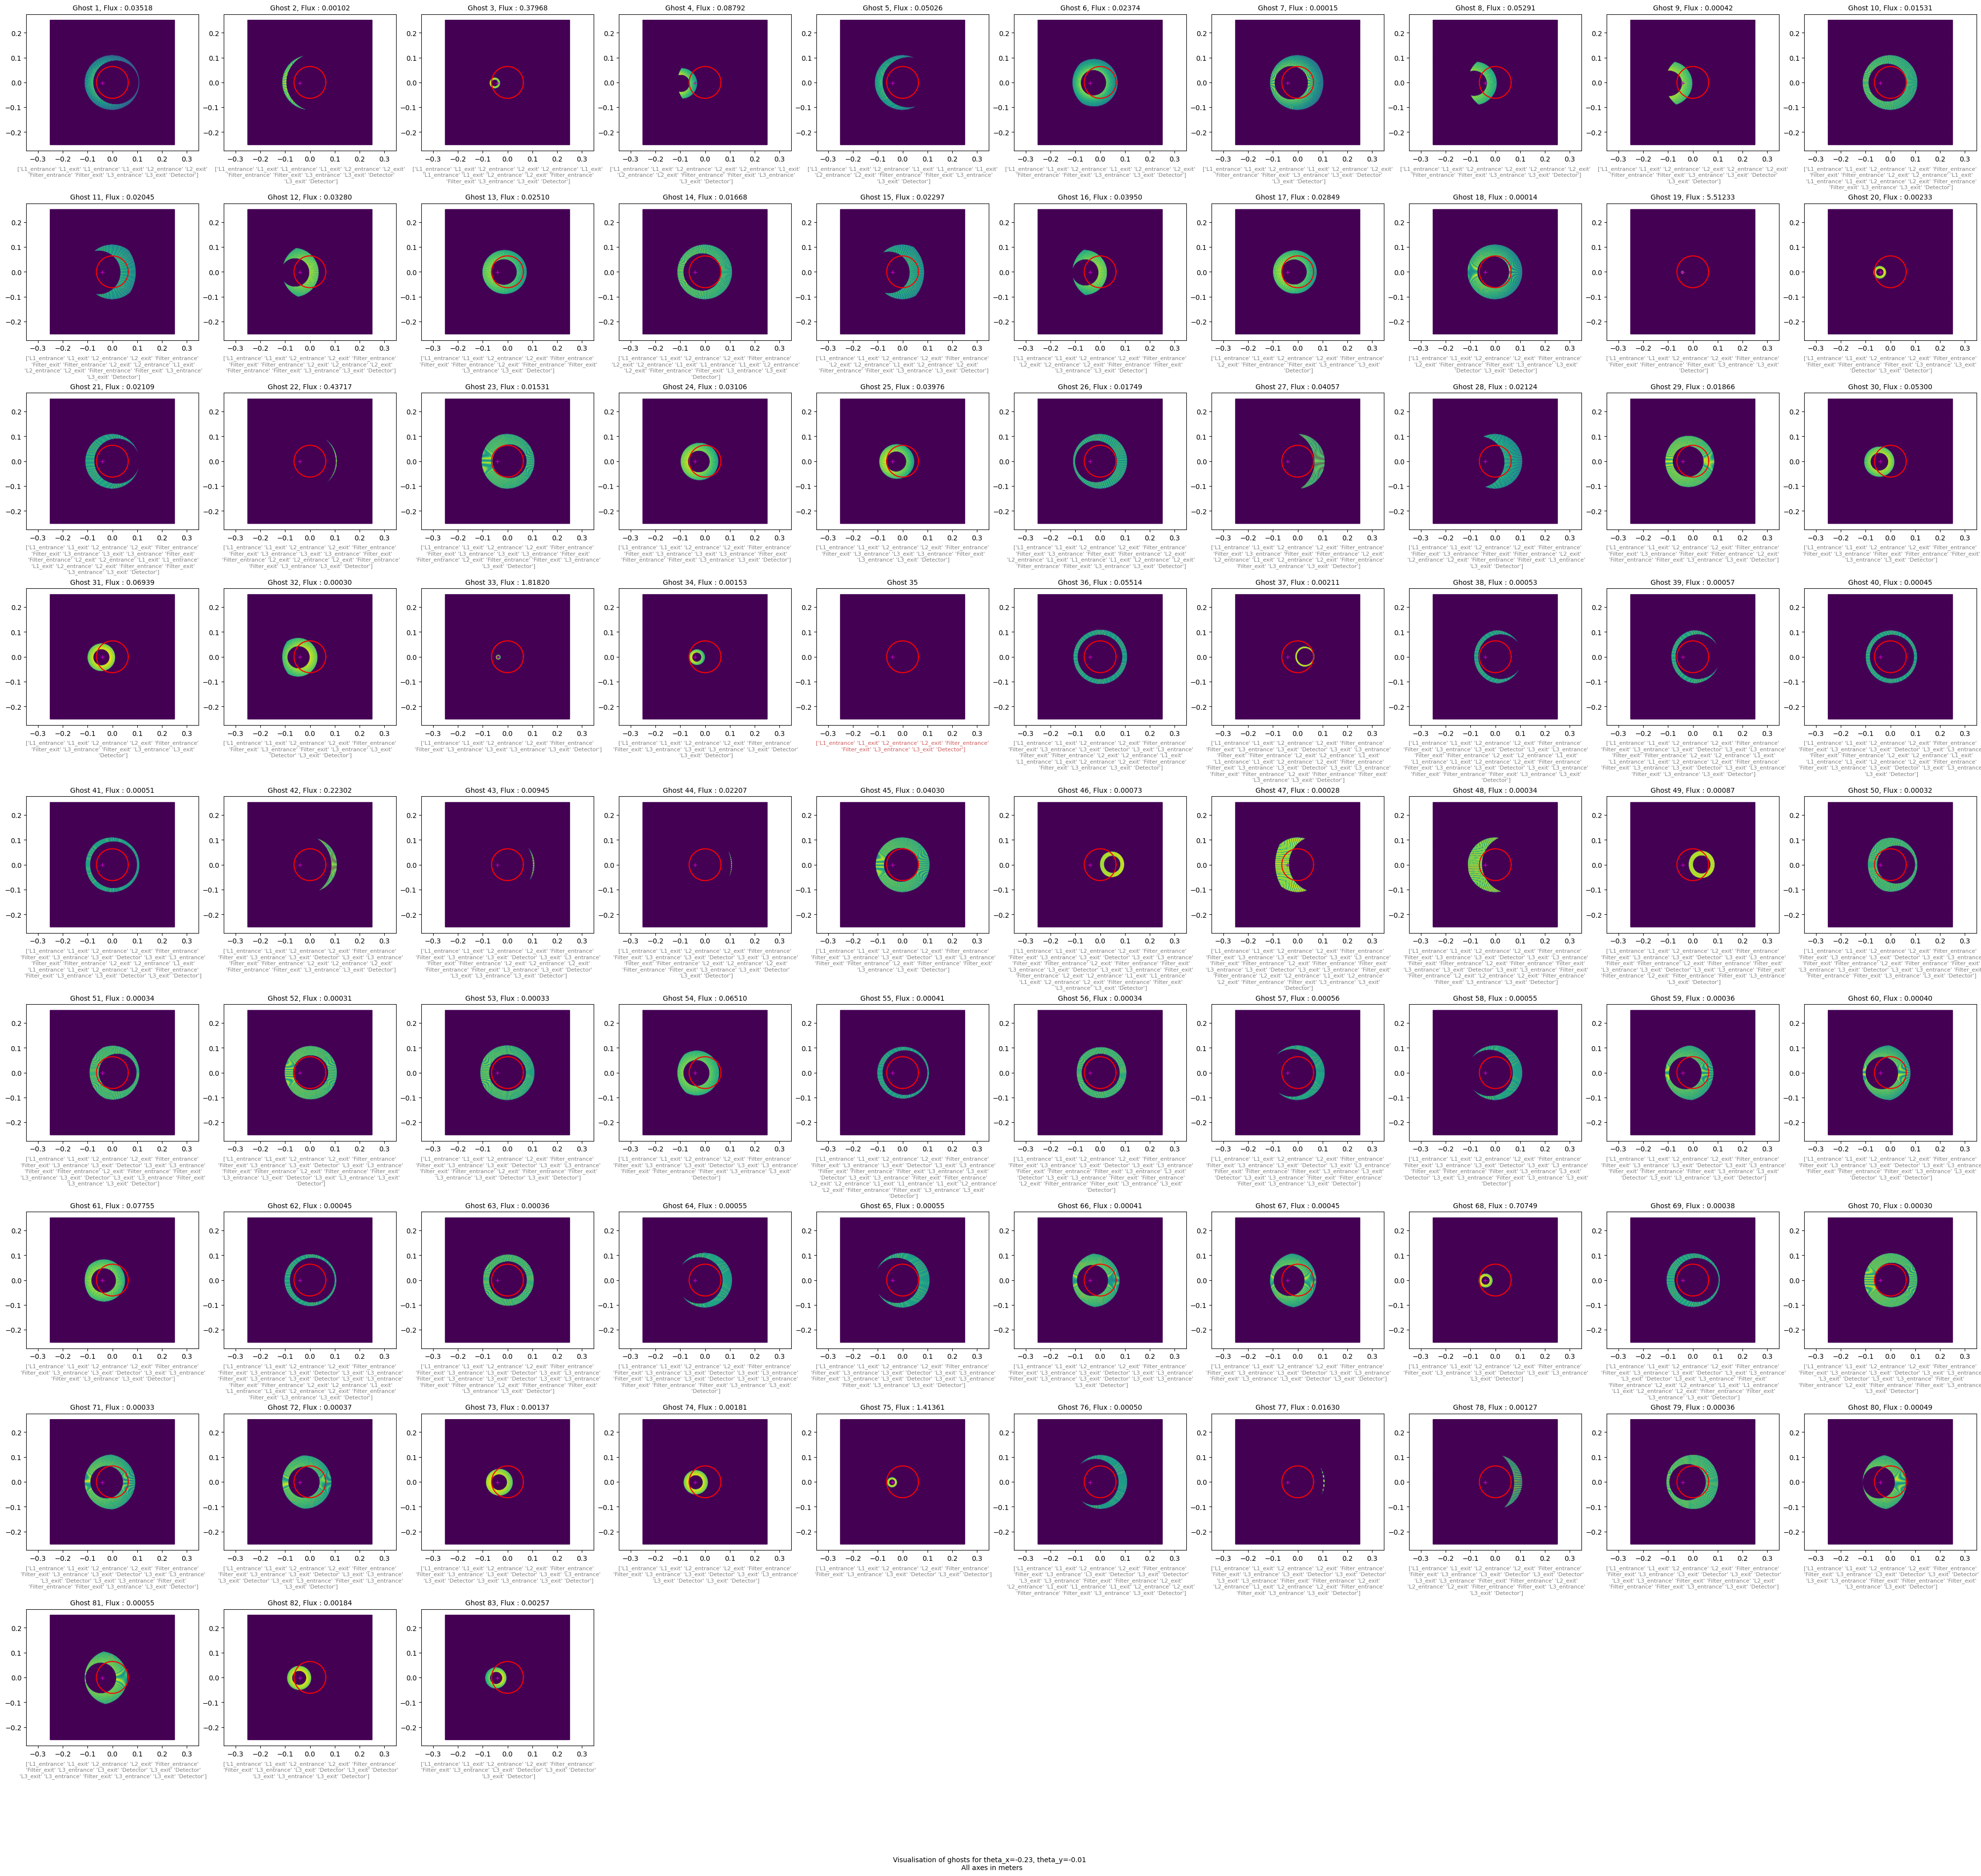

In [11]:
# Initialize subplot
fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), constrained_layout=True)

if nrows == 1 or ncols == 1:
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
else:
    axes = np.array(axes).flatten()

hexbin_collection = [None] * len(rForward)

# Add the data
for i in range(len(rForward)):
    hexbin_collection[i] = axes[i].hexbin(
        rForward[i].x, rForward[i].y, extent=[-0.25, 0.25, -0.25, 0.25],
        gridsize=400
    )
    th = np.linspace(0, 2*np.pi, 1000)
    axes[i].plot(0.32/5*np.cos(th), 0.32/5*np.sin(th), c='r', label="Cercle optique")

    w = np.argmin([len(rrr.path) for rrr in rForward])
    axes[i].plot(np.mean(rForward[w].x), np.mean(rForward[w].y), marker='+', color='m')

    offsets = hexbin_collection[i].get_offsets()
    counts = hexbin_collection[i].get_array()
    
    hex_size = 0.5 / 400
    hex_area = (3 * np.sqrt(3) / 2) * (hex_size ** 2)

    mask = counts > 0
    individual_areas = [hex_area for _ in offsets[mask]]
    
    if str(paths[i]) == str(ref):
        axes[i].set_xlabel(f"{np.array(paths[i])}", fontsize=8, color="indianred", labelpad=5)
        axes[i].set_title(f"Ghost {i+1}", fontsize=10)
    else :
        axes[i].set_xlabel(f"{np.array(paths[i])}", fontsize=8, color="gray", labelpad=5)
        axes[i].set_title(f"Ghost {i+1}, Flux : {rForward[i].flux[0]/(len(individual_areas)*hex_area):.5f}", fontsize=10)
    axes[i].axis("equal")
    
# Mask empty plots
for i in range(len(rForward), len(axes)):
    axes[i].axis("off")

# Add a description under the figure
fig.text(0.5, -0.05, f"Visualisation of ghosts for theta_x={theta_x:.2f}, theta_y={theta_y:.2f} \n All axes in meters", ha="center", fontsize=10)
plt.savefig('all_ghosts.png', bbox_inches='tight')
plt.show()

# How to superpose all ghosts ?

In [44]:
# First you need to fusion all x, y in one array
x_data = np.concatenate([rForward[i].x for i in range(len(rForward))])
y_data = np.concatenate([rForward[i].y for i in range(len(rForward))])
flux_data = np.concatenate([rForward[i].flux for i in range(len(rForward))])

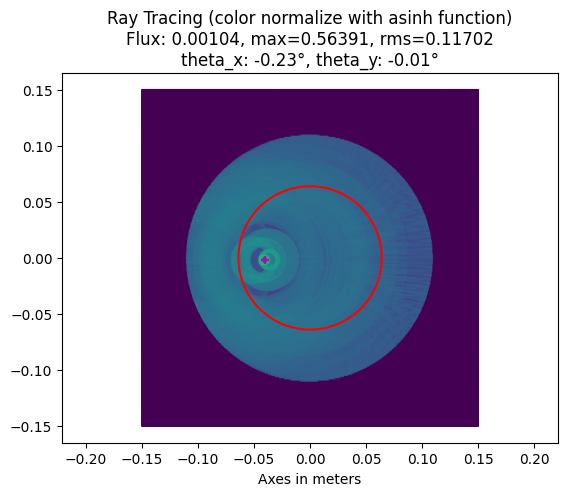

In [45]:
# And you can do it easily
hb = plt.hexbin(
    x_data, y_data, extent=[-0.15, 0.15, -0.15, 0.15],
    gridsize=500, norm=colors.AsinhNorm()
)
th = np.linspace(0, 2*np.pi, 1000)
plt.plot(0.32/5*np.cos(th), 0.32/5*np.sin(th), c='r', label="Cercle optique")

w = np.argmin([len(rrr.path) for rrr in rForward])
plt.scatter(np.mean(rForward[w].x), np.mean(rForward[w].y), marker='+', color='m')

plt.xlabel("Axes in meters")
plt.axis("equal")
plt.title(f"Ray Tracing (color normalize with asinh function)\nFlux: {np.min(flux_data):.5f}, max={np.max(flux_data):.5f}, rms={np.std(flux_data):.5f}\ntheta_x: {theta_x:.2f}°, theta_y: {theta_y:.2f}°")
plt.show()

# How to get the profil along the position of the cross ?

In [46]:
# First you need hexbin's data
counts = hb.get_array()
verts = hb.get_offsets()

# And you select interesting data in an interval along mean of the other axe
interval = 0.02

x_bins = verts[:, 0][np.isclose(verts[:, 1], np.mean(rForward[w].y), atol=interval)]
x_counts = counts[np.isclose(verts[:, 1], np.mean(rForward[w].y), atol=interval)]
    
y_bins = verts[:, 1][np.isclose(verts[:, 0], np.mean(rForward[w].x), atol=interval)]
y_counts = counts[np.isclose(verts[:, 0], np.mean(rForward[w].x), atol=interval)]

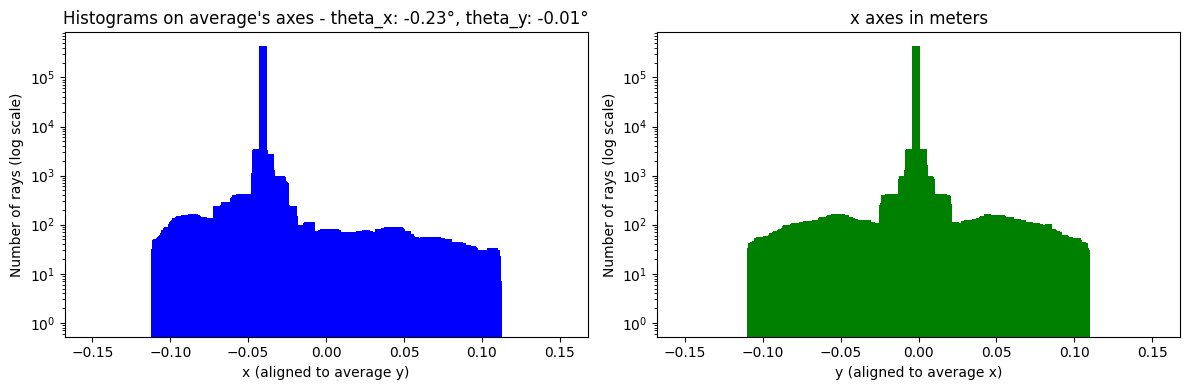

In [47]:
# And you do another subplot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].bar(x_bins, x_counts, width=0.005, color='blue')
ax[0].set_yscale('log')
ax[0].set_xlabel("x (aligned to average y)")
ax[0].set_ylabel("Number of rays (log scale)")

ax[0].set_title(f"Histograms on average's axes - theta_x: {theta_x:.2f}°, theta_y: {theta_y:.2f}°")

ax[1].bar(y_bins, y_counts, width=0.005, color='green')
ax[1].set_yscale('log')
ax[1].set_xlabel("y (aligned to average x)")
ax[1].set_ylabel("Number of rays (log scale)")

ax[1].set_title(f"x axes in meters")
plt.tight_layout()
plt.show()

# How to get a histogram of flux with paths

In [48]:
def get_ghost_path(ghost_path):
    ghost_name_tuple = ('main', 'main')
    for i, opt in enumerate(ghost_path):
        if i >= 2 and ghost_path[i - 2] == opt:
            if ghost_name_tuple == ('main', 'main'):
                ghost_name_tuple = (ghost_path[i - 1],)
            else:
                ghost_name_tuple = (ghost_name_tuple[0], ghost_path[i - 1])
    return ghost_name_tuple

In [49]:
# Stock paths and keep only repeat optics element
path_data = [rForward[i].path for i in range(len(rForward))]
paths = []

for i, ph in enumerate(path_data):
    paths.append(get_ghost_path(ph))

flux_data = [rForward[i].flux for i in range(len(rForward))]
flux_data = [flux_data[i][0] for i in range(len(flux_data))]

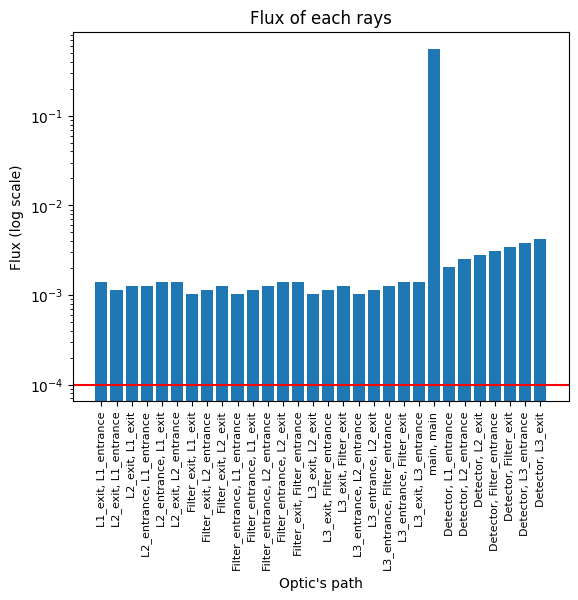

In [50]:
# And you do another subplot
labels = [', '.join(path) for path in paths]
plt.bar(labels, flux_data)
plt.xlabel("Optic's path")
plt.ylabel("Flux (log scale)")
plt.yscale("log")
plt.axhline(1e-4, color="red")
plt.title("Flux of each rays")
plt.tick_params(axis='x', rotation=90, labelsize=8)  # Rotation pour améliorer la lisibilité
plt.show()

# Notes

## 1. Ghosts séparés
- Le path en rouge correspond au chemin de référence (rayon direct). Ce n'est pas un ghost mais l'image direct de l'objet que l'on observe.
- On a besoin d'informations supplémentaires : afficher min, max et rms (std) dans le subtitle (Ghost n : min = ..., max = ..., rms = ...).
- A ce moment là on pourra décrire qualitativement les ghosts.

## 2. Ghosts superposés
- See animation's notebook.

## 3. Histogrammes
- See animation's notebook for the subplot.
- Le rayon direct possède le plus grand flux (rassurant) et on devrait avoir 3 ghosts qui dominent. Seulement, il faudrait étudier le nombre de photons par pixels afin de mieux définir qu'elles ghosts seront clairement distincts sur l'image finale.

# Bonus : How to see a ghost's path in 3d ?

In [51]:
# Stock interesting ghosts
ghosts = [rForward[6] , rForward[7]]

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

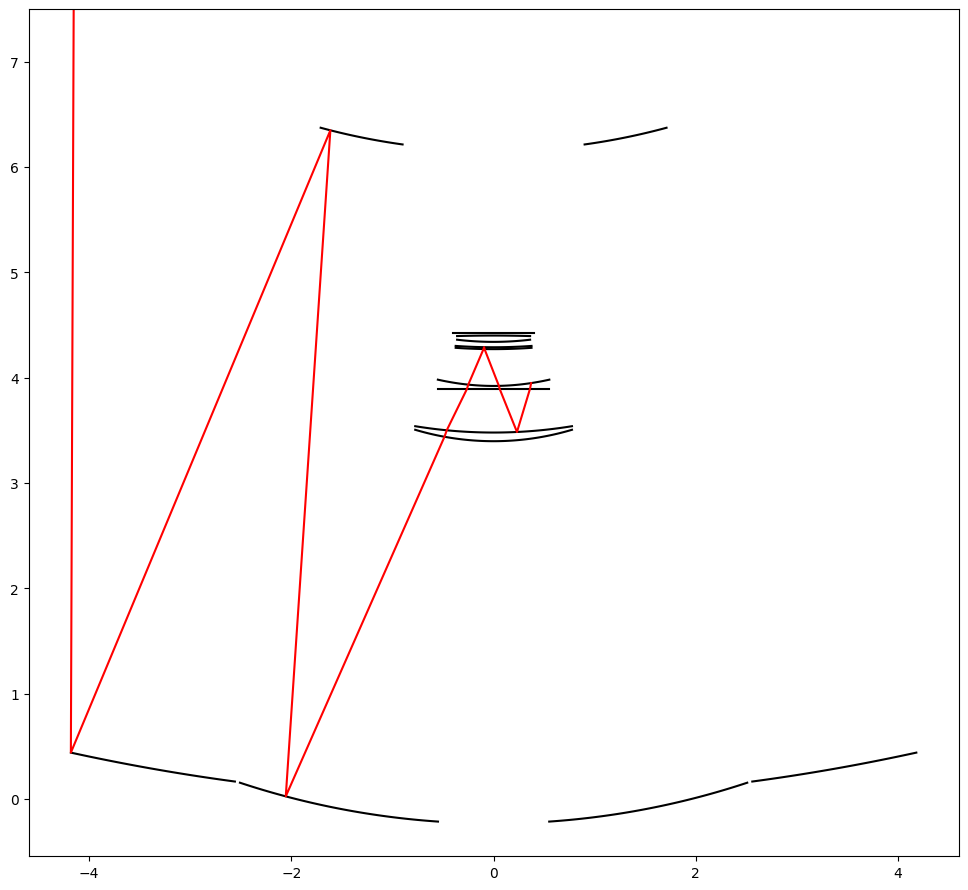

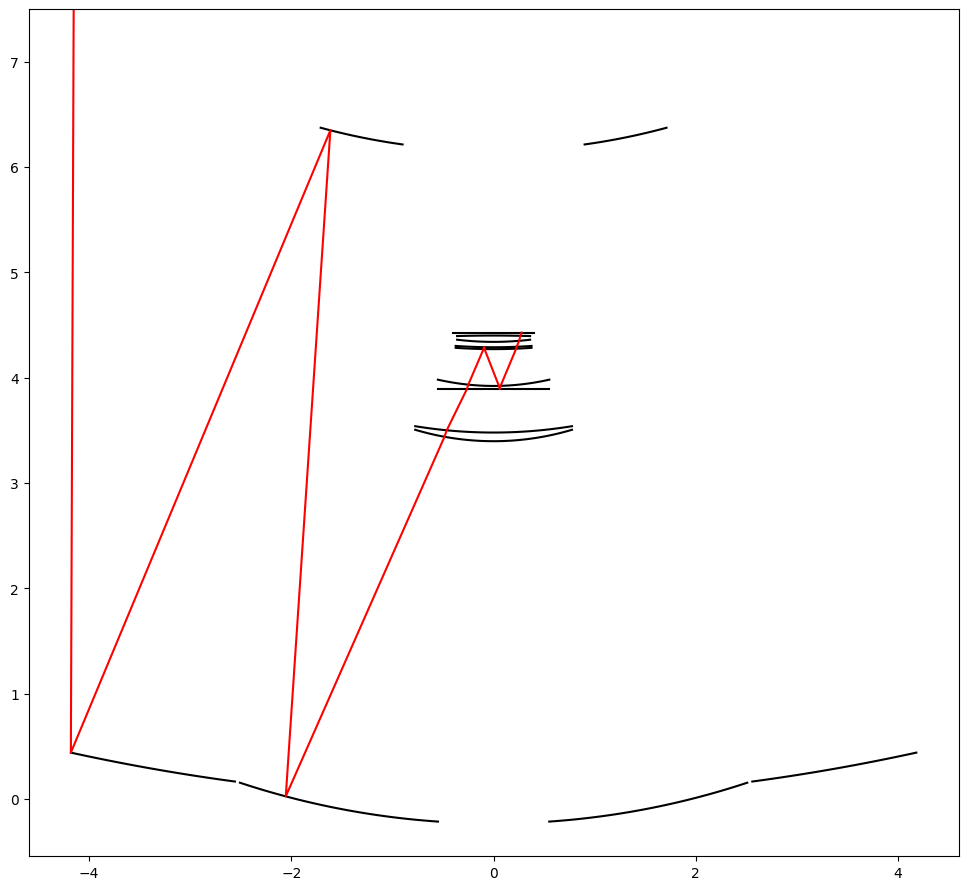

In [60]:
# Import of visualization
import ipyvolume as ipv

telescope = batoid.Optic.fromYaml("LSST_r.yaml")

# Do the calculus with asGrid (for a better visualisation) and less rays
for g in ghosts:
    rays = batoid.concatenateRayVectors([
        batoid.RayVector.asGrid(
            telescope, wavelength=630e-9, 
            theta_x=np.deg2rad(theta_x), theta_y=np.deg2rad(theta_y), 
            nx=2, ny=1
        )#,
        #batoid.RayVector.asGrid(
        #    telescope, wavelength=630e-9, 
        #    theta_x=np.deg2rad(theta_x), theta_y=np.deg2rad(theta_y),
        #    nx=1, ny=1
        #)
        ])

# Generate the interactive plot to see
    fig = plt.figure(figsize=(12, 11))
    ax = fig.add_subplot(111)
    telescope.draw2d(ax, c='k')
    
    tf = telescope.traceFull(rays, path=g.path)
    ax.set_ylim(top=7.5)
    batoid.drawTrace2d(ax, tf, c='r')
    
    ipv.figure(width=700, height=500)
    telescope.draw3d(ipv, color='black')
    batoid.drawTrace3d(ipv, tf, c='r')
    ipv.xlim(-1, 1)
    ipv.ylim(-1, 1)
    ipv.zlim(3, 5)
    ipv.show()